In [1]:
from osgeo import gdal
import sys
import numpy as np
import os

# 给栅格最外圈加一圈
def assignBCs(elevGrid):
    ny, nx = elevGrid.shape
    Zbc = np.zeros((ny + 2, nx + 2))
    Zbc[1:-1, 1:-1] = elevGrid
 
    Zbc[0, 1:-1] = elevGrid[0, :]
    Zbc[-1, 1:-1] = elevGrid[-1, :]
    Zbc[1:-1, 0] = elevGrid[:, 0]
    Zbc[1:-1, -1] = elevGrid[:, -1]
 
    Zbc[0, 0] = elevGrid[0, 0]
    Zbc[0, -1] = elevGrid[0, -1]
    Zbc[-1, 0] = elevGrid[-1, 0]
    Zbc[-1, -1] = elevGrid[-1, 0]
 
    return Zbc

# 计算dx,dy
def calcFiniteSlopes(elevGrid, dx):
    Zbc = assignBCs(elevGrid)
 
    Sx = (Zbc[1:-1, :-2] - Zbc[1:-1, 2:]) / (2 * dx)  # WE方向
    Sy = (Zbc[2:, 1:-1] - Zbc[:-2, 1:-1]) / (2 * dx)  # NS方向
 
    return Sx, Sy

In [2]:
from osgeo import gdal
import sys
import numpy as np
import os
import math
from tqdm import tqdm

# 给栅格最外圈加一圈
def assignBCs(elevGrid):
    ny, nx = elevGrid.shape
    Zbc = np.zeros((ny + 2, nx + 2))
    Zbc[1:-1, 1:-1] = elevGrid
 
    Zbc[0, 1:-1] = elevGrid[0, :]
    Zbc[-1, 1:-1] = elevGrid[-1, :]
    Zbc[1:-1, 0] = elevGrid[:, 0]
    Zbc[1:-1, -1] = elevGrid[:, -1]
 
    Zbc[0, 0] = elevGrid[0, 0]
    Zbc[0, -1] = elevGrid[0, -1]
    Zbc[-1, 0] = elevGrid[-1, 0]
    Zbc[-1, -1] = elevGrid[-1, 0]
 
    return Zbc

# 计算dx,dy
def calcFiniteSlopes(elevGrid, dx):
    Zbc = assignBCs(elevGrid)
 
    Sx = (Zbc[1:-1, :-2] - Zbc[1:-1, 2:]) / (2 * dx)  # WE方向
    Sy = (Zbc[2:, 1:-1] - Zbc[:-2, 1:-1]) / (2 * dx)  # NS方向
 
    return Sx, Sy

In [3]:
if __name__ == '__main__':
    DEMFilename = './使用数据/ASTGTM_N31E113C.img'
    slopeFilename = './输出数据/slope_prj.tif'
 
    gdal.AllRegister()
 
    data = gdal.Open(DEMFilename, gdal.GA_ReadOnly)
    if data is None:
        print('Cannot open this file:' + DEMFilename)
        sys.exit(1)
 
    dx = 30  # 分辨率
  
    gridNew = data.ReadAsArray().astype(np.float16)
 
    Sx, Sy = calcFiniteSlopes(gridNew, dx)
    # 坡度计算
    slope = np.arctan(np.sqrt(Sx ** 2 + Sy ** 2)) * 57.29578
    
    driver = gdal.GetDriverByName('GTiff')
    if os.path.exists(slopeFilename):
        os.remove(slopeFilename)
    srs1 = data.GetProjection()
    geo1 = data.GetGeoTransform()
    ds1 = driver.Create(slopeFilename, slope.shape[1], slope.shape[0], 1, gdal.GDT_Float32)
    ds1.SetProjection(srs1)
    ds1.SetGeoTransform(geo1)
    band = ds1.GetRasterBand(1)
    band.WriteArray(slope, 0, 0)
    
    del ds1
    data = None
    projData = None

In [4]:
if __name__ == '__main__':
    DEMFilename = './使用数据/ASTGTM_N31E113C.img'
    aspectFilename = './输出数据/aspect_prj.tif'
 
    gdal.AllRegister()
 
    data = gdal.Open(DEMFilename, gdal.GA_ReadOnly)
    if data is None:
        print('Cannot open this file:' + DEMFilename)
        sys.exit(1)
 
    dx = 30  # 分辨率
  
    gridNew = data.ReadAsArray().astype(np.float16)
 
    Sx, Sy = calcFiniteSlopes(gridNew, dx)
    
    aspect = np.ones([Sx.shape[0], Sx.shape[1]]).astype(np.float32)
    for i in tqdm(range(Sx.shape[0])):
        for j in range(Sy.shape[1]):
            sx = float(Sx[i, j])
            sy = float(Sy[i, j])
            if (sx == 0.0) & (sy == 0.0):
                aspect[i, j] = -1
            elif sx == 0.0:
                if sy > 0.0:
                    aspect[i, j] = 0.0
                else:
                    aspect[i, j] = 180.0
            elif sy == 0.0:
                if sx > 0.0:
                    aspect[i, j] = 90.0
                else:
                    aspect[i, j] = 270.0
            else:
                aspect[i, j] = float(math.atan2(sy, sx) * 57.29578)
                if aspect[i, j] < 0.0:
                    aspect[i, j] = 90.0 - aspect[i, j]
                elif aspect[i, j] > 90.0:
                    aspect[i, j] = 360.0 - aspect[i, j] + 90.0
                else:
                    aspect[i, j] = 90.0 - aspect[i, j]
                    
    # 输出坡度坡向文件
    driver = gdal.GetDriverByName('GTiff')

    if os.path.exists(aspectFilename):
        os.remove(aspectFilename)
    srs2 = data.GetProjection()
    geo2 = data.GetGeoTransform()
    ds2 = driver.Create(aspectFilename, aspect.shape[1], aspect.shape[0], 1, gdal.GDT_Float32)
    ds2.SetProjection(srs2)
    ds2.SetGeoTransform(geo2)
    band = ds2.GetRasterBand(1)
    band.WriteArray(aspect, 0, 0)
 
    del ds2
    data = None
    projData = None

100%|██████████████████████████████████████████████████████████████████████████████| 3770/3770 [01:18<00:00, 48.19it/s]


In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

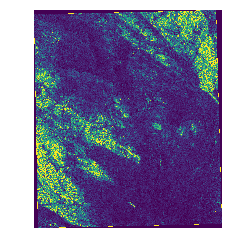

In [10]:
a = np.percentile(slope,98)
b = np.percentile(slope,2)
slope[slope>a]=a
slope[slope<b]=b
plt.axis('off')
plt.imshow(slope)
plt.savefig(r'F:\python林业资源\出图/坡度.png',dpi=300)

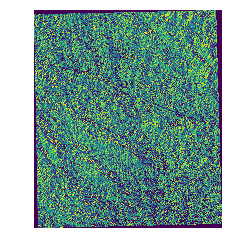

In [9]:
plt.axis('off')
plt.imshow(aspect)
plt.savefig(r'F:\python林业资源\出图/坡向.png',dpi=300)